In [18]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle
import json
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

import nomad.io.base as loader
import nomad.city_gen as cg
import nomad.traj_gen as tg
from nomad.traj_gen import Agent, Population
from nomad.city_gen import City
from nomad.map_utils import blocks_to_mercator_gdf

import nomad.data as data_folder
from pathlib import Path
data_dir = Path(data_folder.__file__).parent
path = data_dir / "garden_city.gpkg"

In [10]:
# Load the city
city_file = data_dir / "garden-city.gpkg"
city = cg.City.from_geopackage(city_file)
start = '2024-06-01 00:00-04:00'

#option 1: symmetric
start_time = pd.date_range(start=start, periods=4, freq='60min')
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*4  # in minutes
location = ['h-x14-y11'] * 1 + ['h-x14-y9'] * 1 + ['w-x17-y10'] * 1 + ['w-x17-y8'] * 1

destinations = pd.DataFrame(
    {
        "datetime":start_time,
         "timestamp":unix_timestamp,
         "duration":duration,
         "location":location
    }
)
destinations = tg.condense_destinations(destinations)
destinations.to_csv("exp_2_destinations_balanced.csv", index=False)

#option 2: we break symmetries to produce more density heterogeneity
start_time = pd.date_range(start=start, periods=8, freq='30min')
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [30]*8 
location = ['h-x14-y11'] * 2 + ['h-x14-y9'] * 1 + ['w-x17-y10'] * 2 + ['w-x17-y8'] * 3

destinations = pd.DataFrame(
    {
        "datetime":start_time,
         "timestamp":unix_timestamp,
         "duration":duration,
         "location":location
    }
)
destinations = tg.condense_destinations(destinations)
destinations.to_csv("exp_2_destinations_unbalanced.csv", index=False)

In [17]:
blocks_to_mercator_gdf(city.buildings_gdf, 1)



TypeError: blocks_to_mercator_gdf() missing 2 required positional arguments: 'false_easting' and 'false_northing'

In [3]:
# option 1 (reduced for quick demo run)
N_reps = 3000
sparsity_samples = 1
config = dict(
    dt = 0.5,
    N = N_reps*sparsity_samples,
    name_count=2,
    name_seed=2025,
    city_file=str(data_dir / "garden-city.gpkg"),
    destination_diary_file='exp_2_destinations_balanced.csv',
    output_files = dict(
        sparse_path='./sparse_traj_2',
        diaries_path='./diaries_2',
        homes_path='./homes_2'
    ),
    agent_params = dict(
        agent_homes='h-x14-y11',
        agent_workplaces='w-x17-y8',
        seed_trajectory=list(range(N_reps*sparsity_samples)),
        seed_sparsity= list(range(N_reps*sparsity_samples)),
        beta_ping= np.repeat(np.linspace(1, 20, sparsity_samples), N_reps).tolist(),
        beta_durations=None,
        beta_start=None,
        ha=0
    )
)
with open('config_no_ha.json', 'w', encoding='utf-8') as f:
    json.dump(config, f, ensure_ascii=False, indent=4)

In [5]:
# Parameters according to the config file
with open('config_no_ha.json', 'r', encoding='utf-8') as f:
    config = json.load(f)
    
# Load city and destination diary from config
city = City.from_geopackage(config["city_file"])
city.compute_gravity(exponent=2.0, use_proxy_hub_distance=False)

# Build POI data from buildings_gdf door info
poi_data = pd.DataFrame({
    'building_id': city.buildings_gdf['id'].values,
    'x': city.buildings_gdf['door_point'].apply(lambda p: p[0]).values,
    'y': city.buildings_gdf['door_point'].apply(lambda p: p[1]).values
})

destinations = pd.read_csv(config["destination_diary_file"], parse_dates=["datetime"])

population = Population(city)
population.generate_agents(
    N=config["N"],
    seed=config["name_seed"], 
    name_count=config["name_count"],
    agent_homes=config["agent_params"]["agent_homes"],
    agent_workplaces=config["agent_params"]["agent_workplaces"]
)

for i, agent in enumerate(tqdm(population.roster.values(), desc="Generating trajectories")):
    agent.generate_trajectory(
        destination_diary=destinations,
        dt=config["dt"],
        seed=config["agent_params"]["seed_trajectory"][i],
        step_seed=config["agent_params"]["seed_trajectory"][i])
    
    agent.sample_trajectory(
        beta_ping=config["agent_params"]["beta_ping"][i],
        seed=config["agent_params"]["seed_sparsity"][i],
        ha=config["agent_params"]["ha"],
        replace_sparse_traj=True)

# Reproject all trajectories to Web Mercator at population level
print("Reprojecting trajectories to Web Mercator...")
population.reproject_to_mercator(sparse_traj=True, full_traj=False, diaries=True, poi_data=poi_data)

Generating trajectories:   0%|          | 0/3000 [00:00<?, ?it/s]/Users/andresmondragon/nomad/nomad/city_gen.py:1582: UserWarning: shortest_paths not initialized. Auto-initializing with callable_only=True. Call compute_shortest_paths() explicitly.
  warnings.warn("shortest_paths not initialized. Auto-initializing with callable_only=True. Call compute_shortest_paths() explicitly.", UserWarning)
Generating trajectories: 100%|██████████| 3000/3000 [01:34<00:00, 31.91it/s]


Reprojecting trajectories to Web Mercator...


In [6]:
# Save output files using save_pop method
print("Saving output files...")
population.save_pop(
    sparse_path=config["output_files"]["sparse_path"],
    diaries_path=config["output_files"]["diaries_path"],
    homes_path=config["output_files"]["homes_path"],
    beta_ping=config["agent_params"]["beta_ping"],
    ha=config["agent_params"]["ha"]
)
print("All output files saved successfully!")

Saving output files...
All output files saved successfully!


In [2]:
traj_df = loader.from_file('sparse_traj_2/part-0.parquet', format='parquet')

In [3]:
traj_df.head()

,x,y,datetime,timestamp,user_id,ha,tz_offset
0,-4.265482e+06,4.393148e+06,2024-06-01 00:00:52,1717214452,admiring_ardinghelli,0.0,-14400
1,-4.265482e+06,4.393148e+06,2024-06-01 00:01:03,1717214463,admiring_ardinghelli,0.0,-14400
2,-4.265482e+06,4.393148e+06,2024-06-01 00:02:32,1717214552,admiring_ardinghelli,0.0,-14400
3,-4.265482e+06,4.393148e+06,2024-06-01 00:03:24,1717214604,admiring_ardinghelli,0.0,-14400
4,-4.265484e+06,4.393150e+06,2024-06-01 00:04:29,1717214669,admiring_ardinghelli,0.0,-14400


In [4]:
diaries_df = loader.from_file('diaries_2/part-0.parquet', format='parquet')

In [5]:
diaries_df

,datetime,timestamp,duration,location,user_id,x,y,tz_offset
0,2024-06-01 00:00:30,1717214430,60,h-x14-y11,admiring_ardinghelli,-4265489.0,4393148.5,-14400
1,2024-06-01 01:00:30,1717218030,1,None,admiring_ardinghelli,NaN,NaN,-14400
2,2024-06-01 01:01:30,1717218090,59,h-x14-y9,admiring_ardinghelli,-4265489.0,4393118.5,-14400
3,2024-06-01 02:00:30,1717221630,120,None,admiring_ardinghelli,NaN,NaN,-14400
4,2024-06-01 00:00:30,1717214430,60,h-x14-y11,admiring_austin,-4265489.0,4393148.5,-14400
...,...,...,...,...,...,...,...,...
11995,2024-06-01 02:00:30,1717221630,120,None,zen_wiles,NaN,NaN,-14400
11996,2024-06-01 00:00:30,1717214430,60,h-x14-y11,zen_wing,-4265489.0,4393148.5,-14400
11997,2024-06-01 01:00:30,1717218030,1,None,zen_wing,NaN,NaN,-14400
11998,2024-06-01 01:02:00,1717218120,58,h-x14-y9,zen_wing,-4265489.0,4393118.5,-14400


In [6]:
destinations = pd.read_csv('exp_2_destinations_unbalanced.csv')

In [7]:
destinations

,datetime,timestamp,duration,location
0,2024-06-01 00:00:00-04:00,1717214400,60,h-x14-y11
1,2024-06-01 01:00:00-04:00,1717218000,30,h-x14-y9
2,2024-06-01 01:30:00-04:00,1717219800,60,w-x17-y10
3,2024-06-01 02:30:00-04:00,1717223400,90,w-x17-y8


In [ ]:
from sklearn.neighbors import KernelDensity
import numpy as np
X = traj_df[['x', 'y']].values
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X)

In [21]:
kde_noise = KernelDensity(kernel='gaussian', bandwidth=10).fit(X)

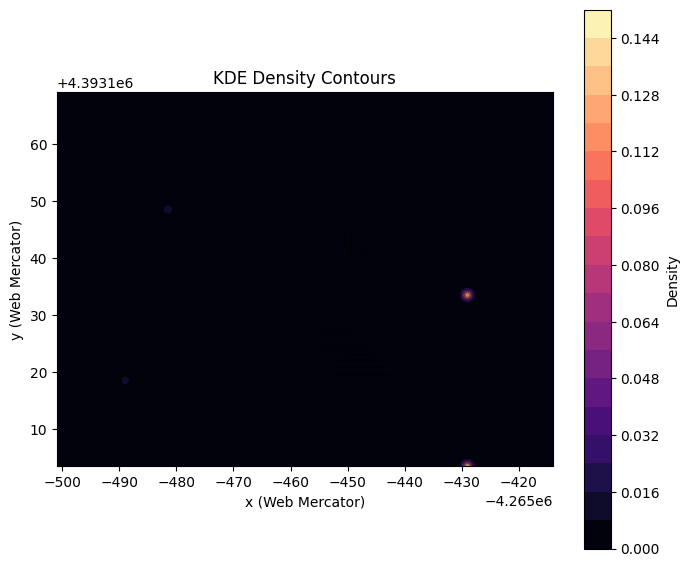

In [22]:
# Build grid over the data range
xmin, xmax = X[:, 0].min(), X[:, 0].max()
ymin, ymax = X[:, 1].min(), X[:, 1].max()

xx, yy = np.meshgrid(
    np.linspace(xmin, xmax, 300),
    np.linspace(ymin, ymax, 300)
)

grid = np.vstack([xx.ravel(), yy.ravel()]).T

# Evaluate log density
log_dens = kde.score_samples(grid)
dens = np.exp(log_dens).reshape(xx.shape)

# --- Plot ---
plt.figure(figsize=(8, 7))
cont = plt.contourf(xx, yy, dens, levels=20, cmap="magma")
plt.contour(xx, yy, dens, colors="black", linewidths=0.25)

plt.xlabel("x (Web Mercator)")
plt.ylabel("y (Web Mercator)")
plt.title("KDE Density Contours")
plt.gca().set_aspect("equal", "box")

cbar = plt.colorbar(cont)
cbar.set_label("Density")

plt.show()